In [30]:
from libscansion import silabas as slbs

2021-12-02 14:39:53 WARNING: Language es package ancora expects mwt, which has been added
2021-12-02 14:39:53 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | ancora  |

2021-12-02 14:39:53 INFO: Use device: cpu
2021-12-02 14:39:53 INFO: Loading: tokenize
2021-12-02 14:39:53 INFO: Loading: mwt
2021-12-02 14:39:53 INFO: Loading: pos
2021-12-02 14:39:54 INFO: Loading: lemma
2021-12-02 14:39:54 INFO: Loading: depparse
2021-12-02 14:39:54 INFO: Loading: ner
2021-12-02 14:39:55 INFO: Done loading processors!


juez
cruel
fiel


In [32]:
from fonemas import transcribe

In [33]:
########################################

In [ ]:
########################################3
# 1. Modules
# 2. Optional visualisation variables
# 3. Preprocessing functions
# 4. Tabular functions
# 5. Statistic functions
# 6. Body

In [2]:
# 1. MODULES

In [1]:
# Import modules

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import collections
import re
from statsmodels.multivariate.manova import MANOVA

In [4]:
# 2. VISUALISATION VARIABLES
# Number of lines shown &c.

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [5]:
# 3. PREPROCESSING FUNCTIONS

In [2]:
# Añade columnas, cambia caracteres problemáticos, corrige columans de vocal escandidas con una librería obsoleta...

def corrigetabla(data):
    data['Vocal'] = ''
    columnas = ['ac1','ac2','ac3','ac4','ac5','ac6','ac7','ac8','ac9','ac10','ac11','ac12','ac13','ac14','ac15']
    # Cambio de +-+-+-+- a X_X_X_X_ para que en las fórmulas no confunda los caracteres con operadores matemáticos
    data['Ritmo'] = data['Ritmo'].str.replace('+','X').str.replace('-','o')
    for columna in columnas:
        data[columna] = data[columna].astype(str).fillna('')
    for index, row in data.iterrows():
        for columna in columnas:
            if len(row[columna]) == 0:
                data.at[index, columna] = ''
            data.at[index, columna] = re.sub('([AEIOU])[aeiou]', '\1', row[columna]).lower()
            data.at[index, columna] = re.sub('[aeiou]([AEIOU])', '\1', row[columna]).lower()
            data.at[index, columna] = re.sub('([aeiou])[iu]', '\1', row[columna]).lower()
            data.at[index, columna] = re.sub('([iu])([aeo])', '\1', row[columna]).lower()
            data.at[index, columna] = re.sub('([AEIOU])[IU]', '\1', row[columna]).lower()
            data.at[index, columna] = re.sub('[IU]([AEO])', '\1', row[columna]).lower()
        letras = ''.join(row[columnas]).replace('<na>','').strip()
        a = collections.Counter(letras).most_common(1)[0][0]
        data.at[index,'Vocal'] = a
    return data

In [5]:
# 4. TABULAR FUNCTIONS

In [39]:
# Defino la función para sacar muestras
# Toma como parámetros un data frame de ritmos,
# una lista de autores,
# y el número de obras por autor
def samples(data, authors, nsamples):
    import numpy as np
    muestra = pd.DataFrame()
    for i in authors:
        g = data.loc[data['Author'] == i].groupby('Title')
        a = np.arange(g.ngroups)
        np.random.shuffle(a)
        sample = sample.append(data.loc[df['Author'] == i][g.ngroup().isin(a[:nsamples])])
    return sample

In [4]:
# Averigua el número de muestras de cada obra y devuelve un df
# con un número de muestras homogéneo para todas las obras
# Toma como parámetros un data frame
# y un entero (opcional) para un máximo de muestras
def muestrasiguales(data, i=0):
    resultado = pd.DataFrame()
    obras = pd.unique(data['Pieza'])
    if i == 0:
        menor = min([len(data[data['Pieza'] == obra]) for obra in obras])
    else:
        menor = 100
    for obra in obras:
        resultado = resultado.append(
# Usamos 42 como valor de aleatorización por tratarse de la respuesta a la vida, el universo y todo (cf. Adams 1979) 
            data[data['Pieza'] == obra].sample(n=menor, random_state = 42), ignore_index=True
        )
    return (resultado, menor)

In [5]:
# Esta función está por si se necesita sacar valores relativos de alguna columna
# Añade una nueva columna con el recuento de ritmos de un tipo por obra y recuento relativo versos/total
# Toma como parámetros un data frame y la columna cuyo valor relativo hay que hallar
def recuento(data, columna):
    dfritmo = pd.DataFrame()
    valores = pd.unique(data[columna])
    obras = pd.unique(data['Pieza'])
    for obra in obras:
        nversos = len(data[data['Pieza'] == obra])
        cuentas = {}
        autor =  data.loc[data['Pieza'] == obra]['Autor'].value_counts()[:1].index.tolist()[0]
        for valor in valores:
            fila = {'Pieza': obra, 'Autor': autor}
            cuenta = len(data.loc[data['Pieza'] == obra][data[columna] == valor])
            relcuenta = cuenta/nversos
            fila = {'Pieza': obra, 'Autor': autor, columna: valor, 'Cuenta': cuenta, 'RelCuenta' : relcuenta}
            if cuenta > 0:           
                dfritmo = dfritmo.append(fila, ignore_index=True)
    return dfritmo.convert_dtypes()

In [6]:
 columnas = ['ac1','ac2','ac3','ac4','ac5','ac6','ac7','ac8','ac9','ac10','ac11','ac12','ac13','ac14','ac15'] columnas = ['ac1','ac2','ac3','ac4','ac5','ac6','ac7','ac8','ac9','ac10','ac11','ac12','ac13','ac14','ac15']# Esta función pasa los valores de ritmo a variables para formar una tabla en formato largo, que 
# se puede usar con MANOVA.wide de R o con las pruebas de scikitlearning
# Toma como valores un data frame y la columna ciyos valores hay que poner en formato largo
# P. ej:
# A B             A a b
# x a     =>      x 2 1
# x a             y 0 3  
# x b
# y b 
# y b 
# y b


def formatolargo(data, columna, cuenta='Cuenta'):
    dflargo = pd.DataFrame()
    obras = pd.unique(data['Pieza'])
    variables = pd.unique(data[columna])
    calderon = lope = mira = 0
    for obra in obras:
        subconjunto = data[data['Pieza'] == obra]
        autor = max(subconjunto['Autor'])
        fila = {'Autor': autor, 'Pieza': obra}
        for var in variables:
            suma = subconjunto[subconjunto[columna] == var]['Cuenta'].sum()
            fila.update({var: suma})
        dflargo = dflargo.append(fila, ignore_index=True)
    return dflargo.convert_dtypes()

In [7]:
# Recorta valores poco relevantes. Ritmos con 2 o menos ocurrencias van fuera
# Toma un data frame y un entero para el mínimo de orcurrencias
def recorta(data, minimo):
    for valor in data.columns:
        #if valor != 'Autor' and valor != 'Pieza':
        if data[valor].dtype.kind in 'biufc':
            if data[valor].sum() < minimo:
                data = data.drop(columns=valor)
    return data.convert_dtypes()

In [8]:
def frecuencia_minima(data, columna, minimo):
    return data.groupby(columna).filter(lambda x : (x[columna].count()>=minimo).any()).convert_dtypes()

In [9]:
def borra(data, columna, ritmosx):
    #data = data.loc[data['Cuenta'] > 10]
    obras = pd.unique(data['Pieza'].values)
    ritmosa = pd.unique(data[columna].values)
    for ritmo in ritmosa:
        if ritmo not in ritmosx:
            data = data.loc[a[columna] != ritmo]
        else:
            for autor in ['Calderón', 'Mira', 'Lope']:
                if ritmo not in data.loc[data['Autor'] == autor][columna].values:
                    data = data.loc[data[columna] != ritmo]
            if len(data[data[columna] == ritmo]) < 20 or data.loc[data[columna] == ritmo]['RelCuenta'].max() < 0.05:
                data = data.loc[data[columna] != ritmo]
    return data

In [10]:
def borrar(data, columna, lista = []):
    data = data.loc[~data['Autor'].isin(control)]
    data = data.loc[~data['Pieza'].str.startswith('z', na=False)]
    #data = data.loc[data['Cuenta'] > 10]
    obras = pd.unique(data['Pieza'].values)
    x = data.loc[data['Autor'].isin(dudosos)]
    a = data.loc[~data['Autor'].isin(dudosos)]
    if len(lista) == 0:
        ritmosx = pd.unique(x[columna].values)
        ritmosa = pd.unique(a[columna].values)
    else:
        return data.loc[data[columna].isin(lista)]
    for ritmo in ritmosa:
        if ritmo not in ritmosx:
            a = a.loc[a[columna] != ritmo]
        else:
            for autor in ['Calderón', 'Mira', 'Lope']:
                if ritmo not in a.loc[a['Autor'] == autor][columna].values:
                    a = a.loc[a[columna] != ritmo]
            if len(a[a[columna] == ritmo]) < 4 or a.loc[a[columna] == ritmo]['Cuenta'].max() < 4:
                a = a.loc[a[columna] != ritmo]
    dfritmo = pd.DataFrame()
    valores = pd.unique(data[columna])
    obras = pd.unique(data['Pieza'])
    for obra in obras:
        cuentas = {}
        autor =  data[data['Pieza'] == obra]['Autor'].value_counts()[:1].index.tolist()[0]
        for valor in valores:
            fila = {'Pieza': obra, 'Autor': autor}
            cuenta = len(data[data['Pieza'] == obra][data[columna] == valor])
            fila = {'Pieza': obra, 'Autor': autor, columna: valor, 'Cuenta': cuenta, 'RelCuenta' : cuenta/len(obra)}
            if cuenta > 0:           
                dfritmo = dfritmo.append(fila, ignore_index=True)
    return dfritmo.convert_dtypes()

In [11]:
#5. STATISTIC FUNCTIONS

In [12]:
# Tests de proximidad
# Toma un data frame largo,un dataframe con el texto a comprobar,
# El tipo de análisis [k]nn, [r]egresión logística, [s]vn 
# real entre 0.0 y 1.0 para el porcentaje de test vs training set,
# entero para la constante de pseudoaleatorización (para poder reproducir el experimento con idénticas condiciones=
# "y" para sacar gráfico de precisión de k-NN u otro string para sacar el valor numérico
# un entero con el número de vecinos para kNN (opcional, usa 3 si no se explicita) 
def analiza(data, j_test=pd.DataFrame(), analisis='k', test=0.2, alea = 42, plot='rbf', n=3):
    X = data.drop('Autor', axis=1).values
    y = data['Autor'].values
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test, random_state=alea)
    #y_train = X_train['Autor'].values
    if analisis == 'k':
        from sklearn.neighbors import KNeighborsClassifier
        neighbors = np.arange(1,12)
        train_accuracy =np.empty(len(neighbors))
        test_accuracy = np.empty(len(neighbors))
    
        for i,k in enumerate(neighbors):
            #Setup a knn classifier with k neighbors
            modelo = KNeighborsClassifier(n_neighbors=k)
            #Fit the model
            modelo.fit(X_train,y_train)
    
            #Compute accuracy on the training set
            train_accuracy[i] = modelo.score(X_train,y_train)
    
            #Compute accuracy on the test set
            test_accuracy[i] = modelo.score(X_test, y_test)
        if plot == 'y':
            # Gráfico para calcular la precisión. Según sus resultados, ajustamos
            # el número de vecinos a un valor óptimo
            plt.rcParams["figure.figsize"] = (10,8)
            plt.title('k-NN número de vecinos')
            plt.plot(neighbors, test_accuracy, label='Precisión de la prueba')
            plt.plot(neighbors, train_accuracy, label='Precisión del entrenamiento')
            plt.legend()
            plt.xlabel('Número de vecinos')
            plt.ylabel('Precisión')
            plt.show()
        else:
            print(test_accuracy)
        modelo = KNeighborsClassifier(n_neighbors=n)
        modelo.fit(X_train,y_train)
    elif analisis == 'r':
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
    
        j_test = sc.transform(j_test)
        from sklearn.linear_model import LogisticRegression
        modelo = LogisticRegression(max_iter=1000,  random_state=alea)
        modelo.fit(X_train,y_train)
        y_pred = modelo.predict(X_test)
    elif analisis == 's':
        from sklearn import svm
        modelo = svm.SVC(kernel=plot)
        modelo.fit(X_train,y_train)
    else:
        return False

    #j_testX = sc.transform(j_testX)

    from sklearn.metrics import classification_report
    print(f'Score: {modelo.score(X_test,y_test)}')
    from sklearn.metrics import confusion_matrix
    y_pred = modelo.predict(X_test)
    # Lo mismo que el gráfico
    #print(confusion_matrix(y_test,y_pred))
    # Ditto
    #print(classification_report(y_test,y_pred))
    print(modelo.predict(j_test))
    #print(f'Prueba: {knn.predict(prueba)}')
    return modelo

In [13]:
# Si hay muchas variables, buscarlas y meterlas a mano para la fórmula de los tests de varianza
# es muy farragoso. Esta función automatiza el trabajo. Acepta como parámetros el data frame en 
# formato alto equivalente al largo y la columna con las variables
def creaformula(columna, data):
    variables = []
    lista = pd.unique(data[columna])
    for idx, elemento in enumerate(lista):
        if idx == 0:
            formula = f'{elemento} ~ Autor'
        else:
            formula = f'{elemento} + {formula}'
        variables += [elemento]
    return formula

In [14]:
#6. AQUÍ EMPIEZA EL PROGRAMA

In [34]:
# Load input file
entrada = 'data.csv'
df = pd.read_csv(entrada)
df.head()

,Author,Title,Genre,Subgenre,Act,Speech,Verse,Character,Type,Gender,Text,Syllables,Ambiguous,Nuclei,Assonance,Consonance,Rhyhtm
0,Lope,Auto del pan y el palo,Auto sacramental,ø,0,1,1,BUEN AÑO,NaN,M,"Espérate, Regocijo,",8,0,eEaeeoIo,io,θixo,-+----+-
1,Lope,Auto del pan y el palo,Auto sacramental,ø,0,1,2,BUEN AÑO,NaN,M,que el viento en las plantas llevas.,8,0,eEeaAaEa,ea,ʎebas,-+--+-+-
2,Lope,Auto del pan y el palo,Auto sacramental,ø,0,2,3,REGOCIJO,NaN,M,Engéndranme buenas nuevas,8,0,eEaeEaEa,ea,nwebas,-+--+-+-
3,Lope,Auto del pan y el palo,Auto sacramental,ø,0,2,4,REGOCIJO,NaN,M,si sabes que soy su hijo.,8,0,iAeeOuIo,io,ixo,-+--+-+-
4,Lope,Auto del pan y el palo,Auto sacramental,ø,0,2,5,REGOCIJO,NaN,M,¿Qué me mandas esperar?,8,0,EeAaeeA,a,ɾaɾ,+-+---+


In [35]:
# Show authors
authors = df['Author'].unique()
print(authors)

['Lope' 'Mira' 'Calderón' 'X']


In [36]:
# Show titles
titles = df['Title'].unique()
print(titles)

['Auto del pan y el palo' 'El heredero' 'El hijo pródigo'
 'El jardín de Falerina' 'El laberinto del mundo' 'El misacantano'
 'El niño pastor' 'El pintor de su deshonra' 'El sacro Pernaso'
 'El viaje del alma' 'La guarda cuidadosa' 'La inquisición' 'La maya'
 'La mayor soberbia humana de Nabucodonosor' 'La santa Margarita'
 'Las bodas entre el Alma y el Amor Divino' 'Los acreedores del hombre'
 'Pedro Telonario' 'Primero y segundo Isaac' 'La hidalga del valle']


In [37]:
# Por comodidad, creo variables para usarlas luego
all_authors = ['Calderón', 'Lope', 'Mira', 'X']
candidates = ['Calderón', 'Lope', 'Mira']
disputed = 'X'

In [38]:
# Recorto solo lo que me interesa. Autores A, B, C y X. 
df = df.loc[df['Syllables'] == 8]

In [28]:
# Tomo tres muestras de cada uno
df = corrigetabla(df)
candidatosdf = samples(df, candidates, 5)

# df con el dudoso
dudosodf = df.loc[df['Autor'] == disputed]

# Junto los dataframes

df = candidatosdf.append(dudosodf, ignore_index=True)

In [31]:
# Elimino ritmos que aparezcan en total menos de 500 veces (He cogido un valor alto para los gráficos del ejemplo,
# en realidad, creo que debería sera alrededor de 100)
df = frecuencia_minima(df, 'Ritmo',  50)

dudosodf = df.loc[df['Autor'] == dudoso]
candidatosdf = df.loc[df['Autor'] != dudoso]

In [32]:
# Conteo de ritmos
dfcuenta = recuento(df, 'Ritmo')

ValueError: No objects to concatenate

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

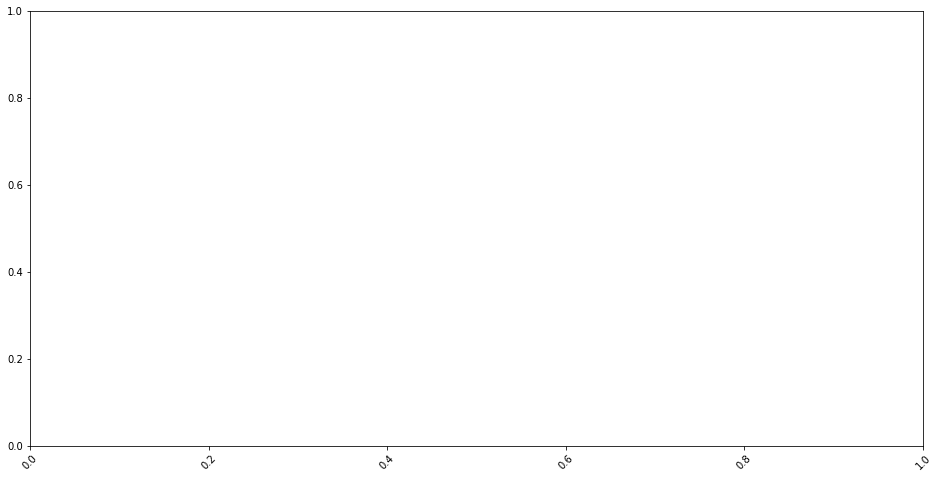

In [33]:
# Histograma
# Este gráfico no tiene sentido para asignación de autoría, pero sí para comparar entre autores si comparamos
# textos del mismo tipo, o sea, comedias con comedias o autos con autos.
#paleta = {"Calderón": "b", "Lope": "green", "Rojas":"orange"}
plt.figure(figsize=(16,8))
plot = sns.histplot(x='Ritmo', hue='Autor', data=candidatosdf, multiple="stack") #, palette=paleta,multiple='stack'
plt.xticks(rotation=45)

In [34]:
# Varianza (cajas)
# Este es multiusos. Podemos comparar entre autores, o ver dónde se ubica un texto dudoso, o comparar entre géneros
# o ... Uso RelCuenta (versos/total) en lugar de cuenta porque en el ejemplo hay comedias y autos mezclados
plt.figure(figsize=(16,8))
plot = sns.boxplot(x='Ritmo', y='Cuenta', hue='Autor', data=dfcuenta, medianprops=dict(color="white", alpha=0.7))
plt.xticks(rotation=45)

NameError: name 'dfcuenta' is not defined

<Figure size 1152x576 with 0 Axes>

In [35]:
# Creo una tabla en formato largo con el ritmo
dflargo = formatolargo(dfcuenta, 'Ritmo', 'Cuenta')

NameError: name 'dfcuenta' is not defined

In [36]:
# Scatterplot (puntos)
plot = sns.scatterplot(data=dflargo, x="oXoXooXo", y="ooXoooXo", hue="Autor")
plt.xticks(rotation=45)

NameError: name 'dflargo' is not defined

In [37]:
# Regresión logística, k-NN y SVN
# Ajusto los parámetros (Porcentaje del corpus para test)
testr = 0.01
testk = 0.2
tests = 0.01
# Factor de aleatorización, para poder repetir el experimento en las mismas condiciones
alea = 42
# Número de vecinos
kn = 3
# Dejo solo las columnas requeridas
data = dflargo.drop('Pieza', axis=1)
autores = candidatos

for autor in  ['DISPUTADO']:
#def analiza(tabla, j_test=pd.DataFrame(), test=0.2, alea = 42, plot='n', analisis='k',  n=12):
    print(f'\n\n\n******************************************\n\nObra:\t{autor}: {dflargo.loc[dflargo["Autor"] == autor]["Pieza"].max()}\n')
    entrenamiento = data.loc[data['Autor'].isin(candidatos)]
    para_comprobar = data.loc[data['Autor'] == autor].drop('Autor', axis=1).values
    
    print('Regresión')
    analiza(entrenamiento, para_comprobar, 'r', testr, alea,'n', 3)
  
    print('\n-------------------------------------------------------\n\nSVN')
    #testY = dfreglargo[dfreglargo['Autor'] == autor].drop('Autor', axis=1).values
    analiza(entrenamiento, para_comprobar,  's', tests, alea, 'rbf')
    
    print('\n-------------------------------------------------------\n\nKnn:\n')
    analiza(entrenamiento, para_comprobar,  'k', testk, alea, 'y', kn)

NameError: name 'dflargo' is not defined

In [38]:
formula = creaformula('Ritmo', df[df['Autor'].isin(candidatos)])

UnboundLocalError: local variable 'formula' referenced before assignment

In [39]:
formula

NameError: name 'formula' is not defined

In [40]:
datos = dflargo[dflargo['Autor'].isin(candidatos)].convert_dtypes()

NameError: name 'dflargo' is not defined

In [41]:
datos.dtypes

NameError: name 'datos' is not defined

In [42]:
#### Hay que convertir las columnas de Pandas a Entero normal!!!
maov = MANOVA.from_formula(formula, data = datos)

NameError: name 'formula' is not defined

In [43]:
#for idx, i in enumerate(pd.unique(dfritmosCLM['Ritmo'])):
    #print(f'anova{idx} <- MANOVA.wide({i}  ~ Autor, data = ridf, iter = 100, resampling = "WildBS", seed=123,CPU = 4)')
    #print(i)

In [44]:
cadena = 'p.adjust(c('
for idx, i in enumerate(pd.unique(dfritmosX['Ritmo'])):
    cadena += f'anova{idx}$resampling[, 2],'
cadena += '), method = "bonferroni")'

NameError: name 'dfritmosX' is not defined

In [45]:
print(maov.mv_test())

NameError: name 'maov' is not defined

test